# Small Molecule Set Covering SMIRNOFF Paramters

Goal: Create a small set of molecules which uses every smirnoff99Frosst parameter.
      Furthermore:
      - The molecules should be as small as possible (preferably <30 atoms)
      - The molecules can come from the Roche set of molecules or eMolecules

## Imports

In [1]:
import time
from collections import defaultdict

import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

import openeye.oechem as oechem
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openforcefield.utils.structure import get_molecule_parameterIDs

## Utilities

In [2]:
def order_id_by_num(pid: str):
    """
    Key for making ids print in order of type then number
    when printed, instead of just alphabetical order.
    """
    return (pid[0], int(pid[1:]))

## Create the set of parameter IDs in smirnoff

In [3]:
# set of all parameter ids
PARAMETER_IDS = set()

# number of parameters of each type
num_params = {'b': 87, 'a': 38, 't': 158, 'n': 35, 'i': 4, }

for (param_type, param_count) in num_params.items():
    for i in range(1, param_count + 1):
        PARAMETER_IDS.add(f"{param_type}{i}")

print('\n'.join(sorted(PARAMETER_IDS, key=order_id_by_num)))

a1
a2
a3
a4
a5
a6
a7
a8
a9
a10
a11
a12
a13
a14
a15
a16
a17
a18
a19
a20
a21
a22
a23
a24
a25
a26
a27
a28
a29
a30
a31
a32
a33
a34
a35
a36
a37
a38
b1
b2
b3
b4
b5
b6
b7
b8
b9
b10
b11
b12
b13
b14
b15
b16
b17
b18
b19
b20
b21
b22
b23
b24
b25
b26
b27
b28
b29
b30
b31
b32
b33
b34
b35
b36
b37
b38
b39
b40
b41
b42
b43
b44
b45
b46
b47
b48
b49
b50
b51
b52
b53
b54
b55
b56
b57
b58
b59
b60
b61
b62
b63
b64
b65
b66
b67
b68
b69
b70
b71
b72
b73
b74
b75
b76
b77
b78
b79
b80
b81
b82
b83
b84
b85
b86
b87
i1
i2
i3
i4
n1
n2
n3
n4
n5
n6
n7
n8
n9
n10
n11
n12
n13
n14
n15
n16
n17
n18
n19
n20
n21
n22
n23
n24
n25
n26
n27
n28
n29
n30
n31
n32
n33
n34
n35
t1
t2
t3
t4
t5
t6
t7
t8
t9
t10
t11
t12
t13
t14
t15
t16
t17
t18
t19
t20
t21
t22
t23
t24
t25
t26
t27
t28
t29
t30
t31
t32
t33
t34
t35
t36
t37
t38
t39
t40
t41
t42
t43
t44
t45
t46
t47
t48
t49
t50
t51
t52
t53
t54
t55
t56
t57
t58
t59
t60
t61
t62
t63
t64
t65
t66
t67
t68
t69
t70
t71
t72
t73
t74
t75
t76
t77
t78
t79
t80
t81
t82
t83
t84
t85
t86
t87
t88
t89
t90
t91
t92
t93
t94
t95
t96


## Read in molecules and get back data on parameter coverage

In [4]:
def load_mol_file(filename):
    """Loads in the given molecule file.
    Returns:
        - OEmols: OpenEye version of the molecule
        - OFFmols: OpenForceField version of the molecule
        - topologies: OpenForceField topologies for each molecule
    """
    ifs = oechem.oemolistream(filename)
    mol = oechem.OEMol()
    mol_count = 0
    OEmols, OFFmols, topologies = [], [], []
 
    while oechem.OEReadMolecule(ifs, mol):
        c_mol = oechem.OEMol(mol)
        oechem.OEAddExplicitHydrogens(c_mol)
        OEmols.append(c_mol)
        OFFmol = Molecule.from_openeye(c_mol, allow_undefined_stereo=True)
        OFFmols.append(OFFmol)
        topologies.append(Topology.from_molecules(OFFmol))
        mol_count += 1
 
    print("%d molecules read" % mol_count)
    return OEmols, OFFmols, topologies

In [5]:
def analyze_parameters(OEmols, OFFmols, topologies):
    """Analyzes the parameters which are present in the set of molecules
    Returns:
        - parameters_by_molecule - a mapping from SMILES strings to a dict containing
            the parameters in the molecule and the atoms where those params matched
        - parameters_by_ID - a mapping from each parameter ID to the SMILES strings
            where the parameter appeared
        - param_ids - a set of all parameter IDs
        - param_id_counts - the number of occurrences of each parameter
        - smirks_by_ID - a mapping from each parameter ID to the set of SMIRKS strings
            where the parameter appeared
    """
    init_time = time.time() # track time

    parameters_by_molecule = dict() # { SMIRKS: {pid1: [(atom indices), (atom indices)...]} }
    parameters_by_ID = defaultdict(set) # { PID: {smirks1,smirks2,...} }
    param_ids = set() # { pid1,pid2,... }
    param_id_counts = dict() # { pid: count }
    smirks_by_ID = defaultdict(set) # { pid: {smirks1,smirks2,...} }
    
    forcefield = ForceField('test_forcefields/smirnoff99Frosst.offxml')

    for mol_idx, topology in enumerate(topologies):
        # Get parameter usage for this molecule
        molecule_force_list = forcefield.label_molecules(topology)

        # Make a SMILES for this molecule
        smi = oechem.OECreateIsoSmiString(OEmols[mol_idx])
        parameters_by_molecule[smi] = defaultdict(list)

        if mol_idx % 10 == 0: print(f'Forces for molecule {mol_idx}')
            
        # Extract and organize parameter usage info
        for force_tag, force_dict in molecule_force_list[0].items():
            for (atom_indices, parameter) in force_dict.items():
                parameters_by_molecule[smi][parameter.id].append(atom_indices)
                parameters_by_ID[parameter.id].add(smi)
                smirks_by_ID[parameter.id].add(parameter.smirks)
                param_ids.add(parameter.id)

    for pid in param_ids: param_id_counts[pid] = 0

    for smi, pid_dict in parameters_by_molecule.items():
        for pid, ind_list in pid_dict.items():
            param_id_counts[pid] += len(ind_list)   

    elapsed = (time.time() - init_time) / 60.0
    print("Organizing dictionaries took %.2f minutes" % (elapsed))
    
    return parameters_by_molecule, parameters_by_ID, param_ids, \
           param_id_counts, smirks_by_ID

In [6]:
def print_non_covered_params(param_ids):
    print(' '.join(sorted(param_ids, key=order_id_by_num)))
    
def find_non_covered_params(param_ids):
    non_covered = PARAMETER_IDS - param_ids
    print_non_covered_params(non_covered)
    return non_covered

In [7]:
# Parameter histograms
# Porting this in exactly from Bannan's code in https://github.com/openforcefield/openforcefield/blob/master/utilities/convert_frosst/parameter_usage.ipynb

def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort(key=order_id_by_num)
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    #print( parm_ids)
    #print( counts_parms)
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()

In [8]:
# Create histogram for each type of parameter
def plot_all_param_histograms(param_id_counts, param_ids):
    # VdW
    make_param_histogram(param_id_counts, param_ids, 'n', "VdW for Roche Molecules")
    # Bonds
    make_param_histogram(param_id_counts, param_ids, 'b', "Bonds for Roche Molecules")
    # Angles
    make_param_histogram(param_id_counts, param_ids, 'a', "Angles for Roche Molecules")
    # Torsions
    make_param_histogram(param_id_counts, param_ids, 't', "Torsions for Roche Molecules")
    # Improper torsions
    make_param_histogram(param_id_counts, param_ids, 'i', "Impropers for Roche Molecules")

## Analyze Roche molecules

In [9]:
Roche_OEmols, Roche_OFFmols, Roche_topologies = load_mol_file("molecules/Roche_compounds.sdf")

Roche_parameters_by_molecule, Roche_parameters_by_ID, \
Roche_param_ids, Roche_param_id_counts, Roche_smirks_by_ID = \
    analyze_parameters(Roche_OEmols, Roche_OFFmols, Roche_topologies)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 24, aromatic: False, chiral: False

Warning (n

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 27, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 12, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 16, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 12, 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 24, aromatic: True, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, arom

468 molecules read
Forces for molecule 0
Forces for molecule 10
Forces for molecule 20
Forces for molecule 30
Forces for molecule 40
Forces for molecule 50
Forces for molecule 60
Forces for molecule 70
Forces for molecule 80
Forces for molecule 90
Forces for molecule 100
Forces for molecule 110
Forces for molecule 120
Forces for molecule 130
Forces for molecule 140
Forces for molecule 150
Forces for molecule 160
Forces for molecule 170
Forces for molecule 180
Forces for molecule 190
Forces for molecule 200
Forces for molecule 210
Forces for molecule 220
Forces for molecule 230
Forces for molecule 240
Forces for molecule 250
Forces for molecule 260
Forces for molecule 270
Forces for molecule 280
Forces for molecule 290
Forces for molecule 300
Forces for molecule 310
Forces for molecule 320
Forces for molecule 330
Forces for molecule 340
Forces for molecule 350
Forces for molecule 360
Forces for molecule 370
Forces for molecule 380
Forces for molecule 390
Forces for molecule 400
Forces f

In [10]:
Roche_non_covered_param_ids = find_non_covered_params(Roche_param_ids)

a12 a26 a29 a33 a34 a36 a37 a38 b21 b22 b24 b25 b27 b28 b29 b30 b31 b32 b35 b37 b40 b41 b42 b43 b44 b45 b46 b47 b48 b50 b51 b52 b55 b57 b58 b59 b60 b61 b62 b63 b64 b65 b66 b70 b71 b72 b73 b74 b75 b76 b77 b78 b79 b80 b81 b82 b85 n1 n5 n10 n13 n22 n25 n26 n27 n28 n29 n30 n31 n32 n33 n34 n35 t6 t7 t8 t11 t12 t18 t19 t25 t26 t28 t30 t31 t32 t34 t36 t37 t38 t49 t53 t54 t55 t56 t57 t58 t60 t63 t65 t78 t79 t80 t81 t82 t83 t89 t90 t93 t99 t100 t102 t103 t104 t105 t114 t115 t116 t117 t118 t119 t121 t122 t123 t124 t125 t126 t127 t131 t132 t133 t134 t144 t146 t147 t148 t149 t150 t151 t152 t153 t154 t155 t156 t158


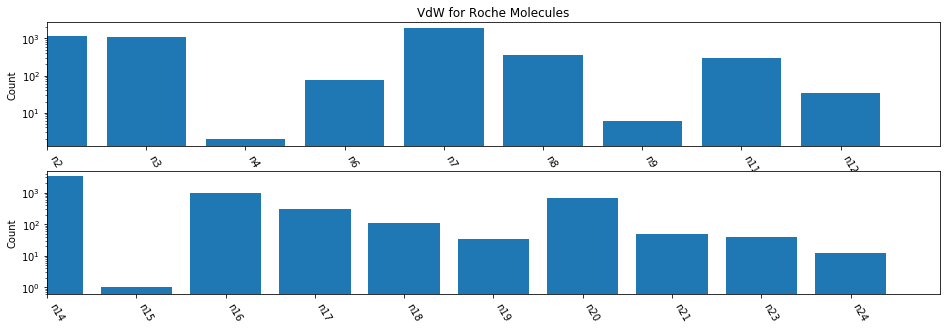

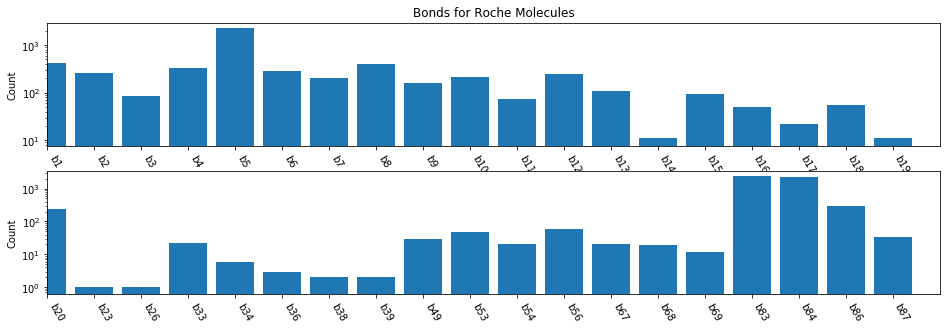

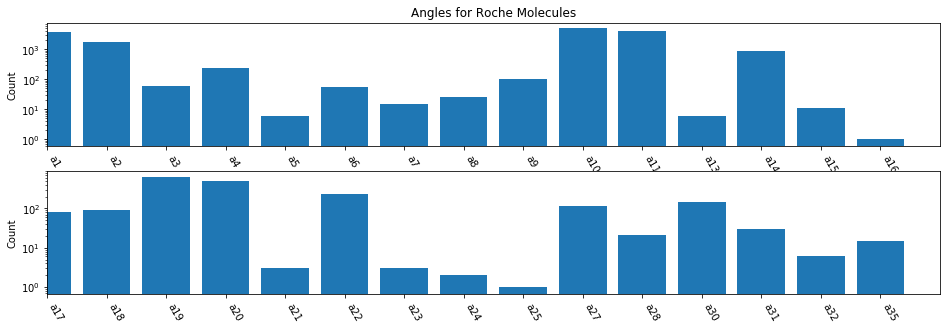

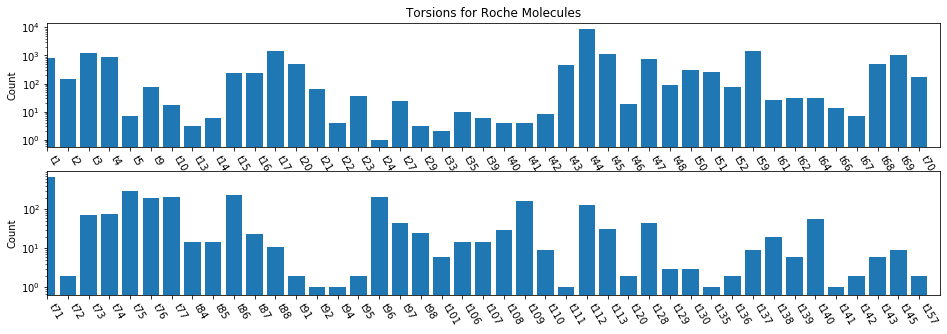

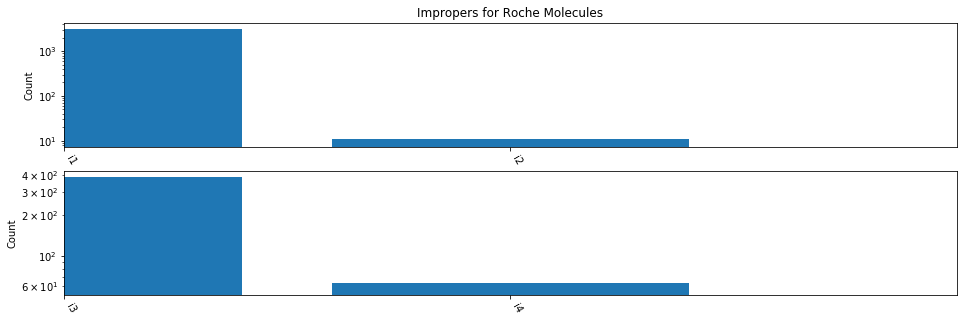

In [11]:
plot_all_param_histograms(Roche_param_id_counts, Roche_param_ids)

## Analyze eMolecules first ~1K

In [12]:
eMolecules_OEmols, eMolecules_OFFmols, eMolecules_topologies = load_mol_file("molecules/emolecules-1k.smi")

eMolecules_parameters_by_molecule, eMolecules_parameters_by_ID, \
eMolecules_param_ids, eMolecules_param_id_counts, eMolecules_smirks_by_ID = \
    analyze_parameters(eMolecules_OEmols, eMolecules_OFFmols, eMolecules_topologies)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 9988 9988
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 17, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 58, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 9990 9990
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic nu

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 10047 10047
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7fa3173b5b10> >]

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 10051 10051
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 14535 14535
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 19, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 14547 14547
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 24822 24822
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 13, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 24852 24852
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 25204 25204
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 20, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 25215 25215
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 25690 25690
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 13, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 26616 26616
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27278 27278
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 26, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27305 27305
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27501 27501
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 17, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 11, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27540 27540
Problematic atoms are:
Atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27908 27908
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 13, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 27910 27910
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 28654 28654
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 28656 28656
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29000 29000
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 20, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 17, name: , idx: 10, aromatic: False, chiral: False
b

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29330 29330
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 13, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29601 29601
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29603 29603
Problematic atoms are:
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 8,

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29814 29814
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7fa31674ccf0> >]

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 29816 29816
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 18, aromatic: False, chiral: False
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7fa31674c30

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 30335 30335
Problematic atoms are:
Atom atomic num: 6, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 22, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 30385 30385
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 31076 31076
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 19, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 31538 31538
Problematic bonds are: [<openeye.oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x7fa3164410f0> >]

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 31539 3

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 32777 32777
Problematic atoms are:
Atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 20, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 32785 32785
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 33950 33950
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 24, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 33996 33996
Problematic atoms are:
Atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 34632 34632
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 7, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 23, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 34638 34638
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 34862 34862
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 17, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 7, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 13, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 34878 34878
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 35346 35346
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 35360 35360
Problematic atoms are:
Atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 35711 35711
Problematic atoms are:
Atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 12, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 35717 35717
Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 

1000 molecules read
Forces for molecule 0
Forces for molecule 10
Forces for molecule 20
Forces for molecule 30
Forces for molecule 40
Forces for molecule 50
Forces for molecule 60
Forces for molecule 70
Forces for molecule 80
Forces for molecule 90
Forces for molecule 100
Forces for molecule 110
Forces for molecule 120
Forces for molecule 130
Forces for molecule 140
Forces for molecule 150
Forces for molecule 160
Forces for molecule 170
Forces for molecule 180
Forces for molecule 190
Forces for molecule 200
Forces for molecule 210
Forces for molecule 220
Forces for molecule 230
Forces for molecule 240
Forces for molecule 250
Forces for molecule 260
Forces for molecule 270
Forces for molecule 280
Forces for molecule 290
Forces for molecule 300
Forces for molecule 310
Forces for molecule 320
Forces for molecule 330
Forces for molecule 340
Forces for molecule 350
Forces for molecule 360
Forces for molecule 370
Forces for molecule 380
Forces for molecule 390
Forces for molecule 400
Forces 

In [13]:
eMolecules_non_covered_param_ids = find_non_covered_params(eMolecules_param_ids)

a29 b22 b28 b31 b37 b43 b47 b50 b51 b61 b64 b65 b75 b77 b78 b79 b81 b82 n29 n30 n32 t18 t19 t26 t30 t33 t34 t36 t37 t39 t40 t53 t54 t55 t58 t63 t64 t79 t80 t81 t82 t83 t91 t92 t93 t94 t95 t102 t103 t104 t105 t113 t116 t119 t123 t124 t127 t131 t132 t133 t135 t142 t144 t145 t146 t147 t149 t153


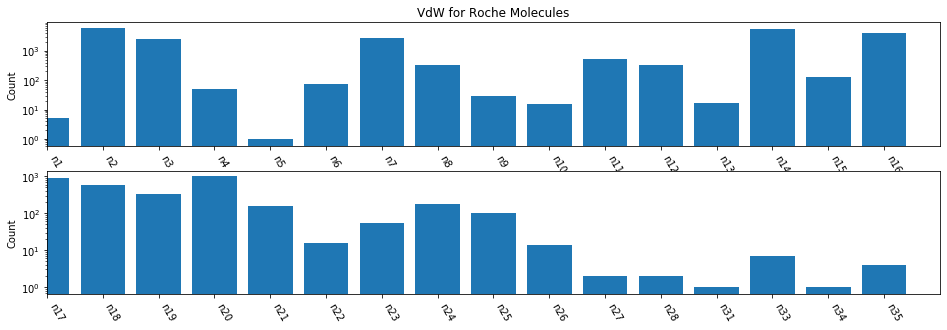

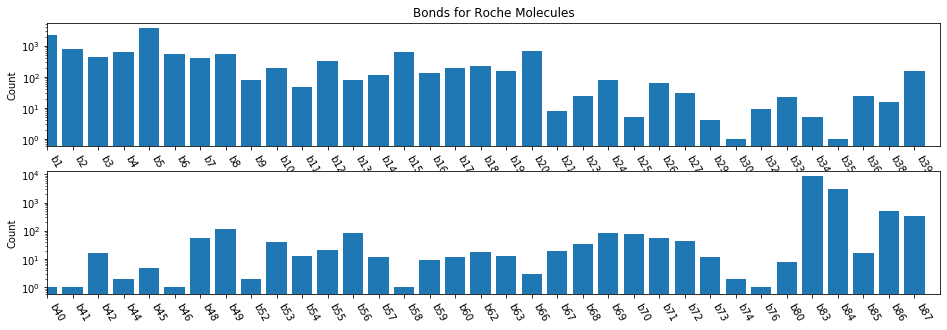

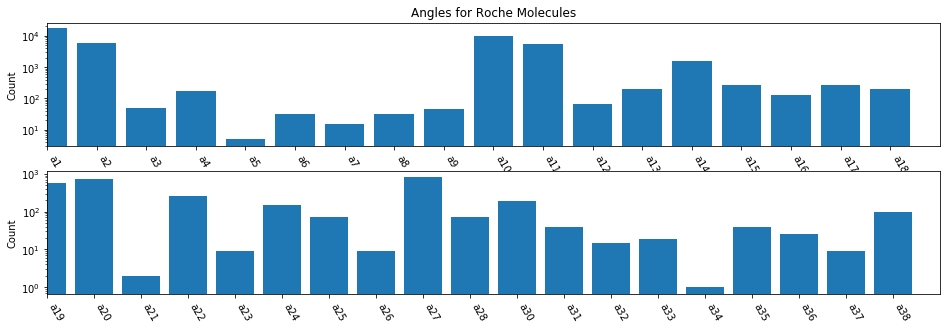

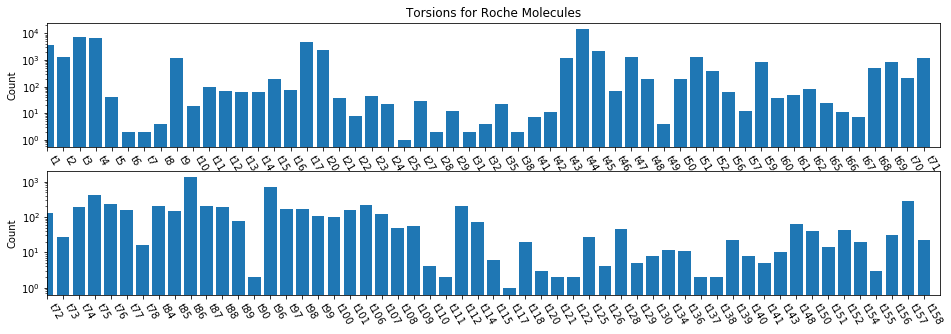

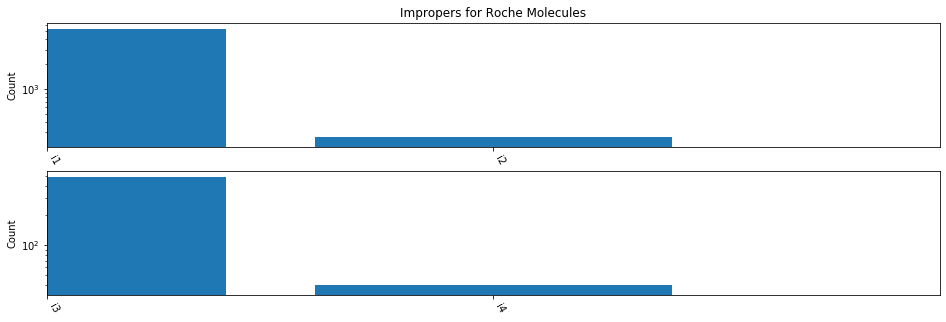

In [14]:
plot_all_param_histograms(eMolecules_param_id_counts, eMolecules_param_ids)

## Analyze eMolecules first ~10K

In [ ]:
eMolecules_10k_OEmols, eMolecules_10k_OFFmols, eMolecules_10k_topologies = load_mol_file("molecules/emolecules-10k.smi")

eMolecules_10k_parameters_by_molecule, eMolecules_10k_parameters_by_ID, \
eMolecules_10k_param_ids, eMolecules_10k_param_id_counts, eMolecules_10k_smirks_by_ID = \
    analyze_parameters(eMolecules_10k_OEmols, eMolecules_10k_OFFmols, eMolecules_10k_topologies)

In [ ]:
eMolecules_10k_non_covered_param_ids = find_non_covered_params(eMolecules_10k_param_ids)

In [ ]:
plot_all_param_histograms(eMolecules_10k_param_id_counts, eMolecules_10k_param_ids)

## Compare non-covered

In [16]:
print(f"{len(Roche_non_covered_param_ids)} ids not covered in Roche")
print()
print_non_covered_params(Roche_non_covered_param_ids)

145 ids not covered in Roche

a12 a26 a29 a33 a34 a36 a37 a38 b21 b22 b24 b25 b27 b28 b29 b30 b31 b32 b35 b37 b40 b41 b42 b43 b44 b45 b46 b47 b48 b50 b51 b52 b55 b57 b58 b59 b60 b61 b62 b63 b64 b65 b66 b70 b71 b72 b73 b74 b75 b76 b77 b78 b79 b80 b81 b82 b85 n1 n5 n10 n13 n22 n25 n26 n27 n28 n29 n30 n31 n32 n33 n34 n35 t6 t7 t8 t11 t12 t18 t19 t25 t26 t28 t30 t31 t32 t34 t36 t37 t38 t49 t53 t54 t55 t56 t57 t58 t60 t63 t65 t78 t79 t80 t81 t82 t83 t89 t90 t93 t99 t100 t102 t103 t104 t105 t114 t115 t116 t117 t118 t119 t121 t122 t123 t124 t125 t126 t127 t131 t132 t133 t134 t144 t146 t147 t148 t149 t150 t151 t152 t153 t154 t155 t156 t158


In [17]:
print(f"{len(eMolecules_non_covered_param_ids)} ids not covered in eMolecules first 1000")
print()
print_non_covered_params(eMolecules_non_covered_param_ids)

68 ids not covered in eMolecules first 1000

a29 b22 b28 b31 b37 b43 b47 b50 b51 b61 b64 b65 b75 b77 b78 b79 b81 b82 n29 n30 n32 t18 t19 t26 t30 t33 t34 t36 t37 t39 t40 t53 t54 t55 t58 t63 t64 t79 t80 t81 t82 t83 t91 t92 t93 t94 t95 t102 t103 t104 t105 t113 t116 t119 t123 t124 t127 t131 t132 t133 t135 t142 t144 t145 t146 t147 t149 t153


In [ ]:
print(f"{len(eMolecules_10k_non_covered_param_ids)} ids not covered in eMolecules first 10000")
print()
print_non_covered_params(eMolecules_10k_non_covered_param_ids)